In [1]:
%%HTML
<style>
p {
    color: #343a40;
}

h1 a.anchor-link {
    color: #F7ECCB;
}

h1 {
    background-color: #343a40;
    width: fit-content;
    padding: 15px;
    color: white;
    text-align: center;
    width: 100%;
}

.intro {
    width: 60%;
    margin: auto;
    text-align: justify !important;
    font-family: Georgia;
}

.output_png {
    display: flex;
    align-items: center;
    justify-content: center;
}

.hide_btn {
    background-color: #343a40;
    padding: 15px;
    color: white;
    border-radius: 30px;
    border: none;
}
</style>

In [2]:
%%HTML
<script>
    code_show=true;
    function code_toggle() {
         if (code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input class='hide_btn' type="submit"
    value="Toggle code">
</form>

In [3]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [22]:
from skimage.io import imread, imshow
from skimage.transform import downscale_local_mean
from skimage.color import rgb2gray, rgb2hsv, gray2rgb
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution
from skimage.morphology import closing, opening, area_closing, area_opening, erosion, dilation
from skimage.measure import label, regionprops, regionprops_table
from skimage import transform
from skimage.filters import threshold_otsu

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import norm
from scipy.signal import convolve2d

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Chapter 8: Leaves from the vine

<p class='intro'><br>Dear diary,<br>
The most surreal thing just happened. I realize now that I was being totally crazy. He made me realize that. I came to his door today, having found it previously using some image processing techniques. I had fully intended to confess my love to him. But when I knocked on his door, he opened it. And I saw something that didn't make sense. He was wearing a most unusual garb, and for some reason, leaves were falling from all around him. He took one look at me, and he took a deep breath. I felt like a rush of water overcame me, followed by the sting of flames. . . Like perhaps the sun was breathing on me. And then. . . he was gone.
</p>
<p class='intro'><i>I don't understand.</i></p>

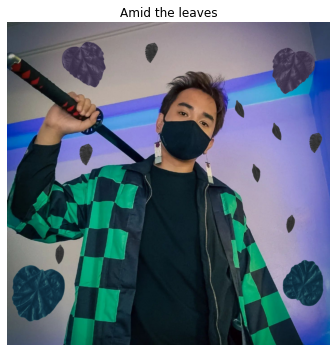

In [7]:
ch8 = imread('images/ch8.png')
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Amid the leaves')
plt.tight_layout()
plt.imshow(ch8);

I had my camera prepared at the time, so I was able capture the moment right before he disappeared. I think. . . maybe those leaves have something to do with it. I need to isolate those leaves and discover what hidden properties they posses.

In [8]:
img_files = os.listdir('images/leaves')

img_files = [(x.split('_')[0].split('.')[0][-1], 'images/leaves/' + x) for x in img_files]

img_df = pd.DataFrame(img_files, columns=['type', 'path'])
img_df

,type,path
0,A,images/leaves/plantA_1.jpg
1,A,images/leaves/plantA_10.jpg
2,A,images/leaves/plantA_11.jpg
3,A,images/leaves/plantA_12.jpg
4,A,images/leaves/plantA_13.jpg
5,A,images/leaves/plantA_2.jpg
6,A,images/leaves/plantA_3.jpg
7,A,images/leaves/plantA_4.jpg
8,A,images/leaves/plantA_5.jpg
9,A,images/leaves/plantA_6.jpg


I collected some leaf samples that looked like they could be similar to the ones in his picture.

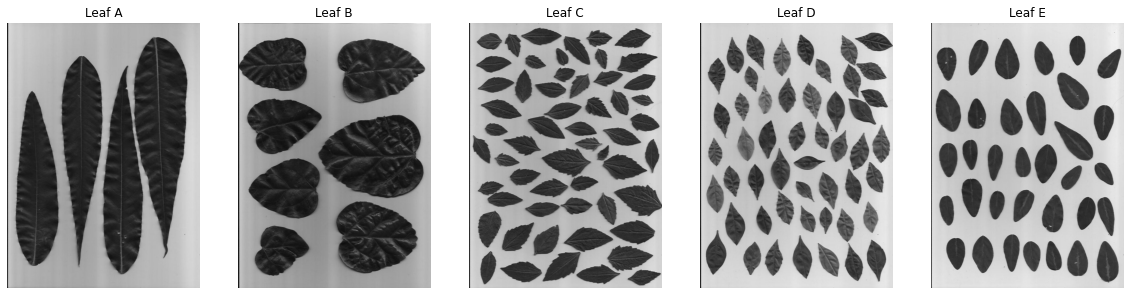

In [9]:
a_sample = imread('images/leaves/plantA_1.jpg')
b_sample = imread('images/leaves/plantB_1.jpg')
c_sample = imread('images/leaves/plantC.jpg')
d_sample = imread('images/leaves/plantD.jpg')
e_sample = imread('images/leaves/plantE_1.jpg')
imgs = [a_sample, b_sample, c_sample, d_sample, e_sample,]
titles = ['Leaf A', 'Leaf B', 'Leaf C', 'Leaf D', 'Leaf E',]

fig, axs = plt.subplots(1, 5, figsize=(20,8))

for i, ax in enumerate(axs):
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.set_title(titles[i]);

They were in three channels, but all with the same value, so turning these images into 2D grayscale would make sense.

In [10]:
a_sample

array([[[ 13,  13,  13],
        [ 12,  12,  12],
        [ 28,  28,  28],
        ...,
        [188, 188, 188],
        [189, 189, 189],
        [189, 189, 189]],

       [[ 14,  14,  14],
        [ 13,  13,  13],
        [ 28,  28,  28],
        ...,
        [189, 189, 189],
        [189, 189, 189],
        [189, 189, 189]],

       [[ 17,  17,  17],
        [ 14,  14,  14],
        [ 28,  28,  28],
        ...,
        [189, 189, 189],
        [190, 190, 190],
        [190, 190, 190]],

       ...,

       [[ 14,  14,  14],
        [ 27,  27,  27],
        [ 58,  58,  58],
        ...,
        [202, 202, 202],
        [203, 203, 203],
        [205, 205, 205]],

       [[ 13,  13,  13],
        [ 25,  25,  25],
        [ 53,  53,  53],
        ...,
        [201, 201, 201],
        [202, 202, 202],
        [205, 205, 205]],

       [[ 11,  11,  11],
        [ 23,  23,  23],
        [ 49,  49,  49],
        ...,
        [199, 199, 199],
        [202, 202, 202],
        [205, 205, 205]]

And these are what each leaf looks like. Very interesting. Their shapes and sizes are completely different, especially between leaves A, B, and then C, D and E. Leaf A is long and thin. Leaf B hurts to look at, heart-shaped leaves. . . like the heart-shaped hole he left in me. Leaf C is small and pointy, similar to Leaf D, but it has ragged edges. Leaf E is shaped kind of like mini-avocadoes to me.

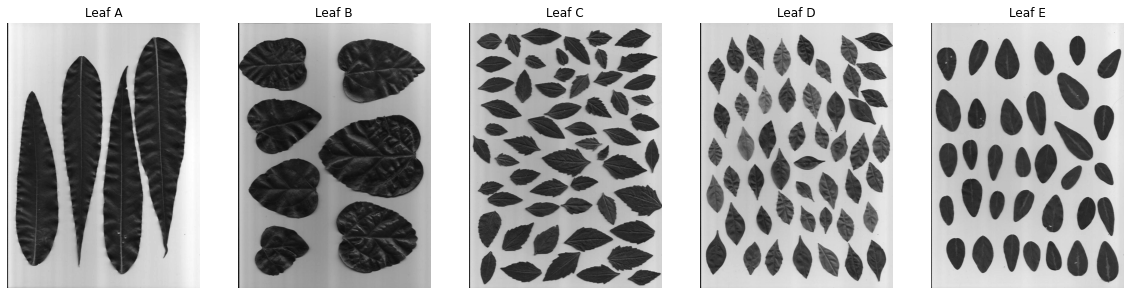

In [11]:
gray_imgs = [rgb2gray(x) for x in imgs]
titles = ['Leaf A', 'Leaf B', 'Leaf C', 'Leaf D', 'Leaf E',]

fig, axs = plt.subplots(1, 5, figsize=(20,8))

for i, ax in enumerate(axs):
    ax.imshow(gray_imgs[i], cmap='gray')
    ax.axis('off')
    ax.set_title(titles[i]);

I have to binarize these images to isolate the leaves.

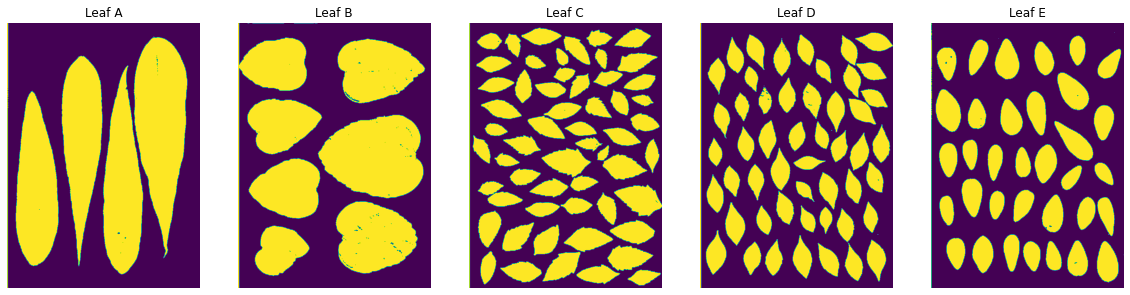

In [12]:
thresholds = [threshold_otsu(x) for x in gray_imgs]
binarized_imgs = [x < thresholds[i] for i, x in enumerate(gray_imgs)]
titles = ['Leaf A', 'Leaf B', 'Leaf C', 'Leaf D', 'Leaf E',]

fig, axs = plt.subplots(1, 5, figsize=(20,8))

for i, ax in enumerate(axs):
    ax.imshow(binarized_imgs[i])
    ax.axis('off')
    ax.set_title(titles[i]);

After binarization, I have to clean them up with some openings and closings. I wonder. . . Has my opening to enter his life just closed forever? He just disappeared, I really don't understand.

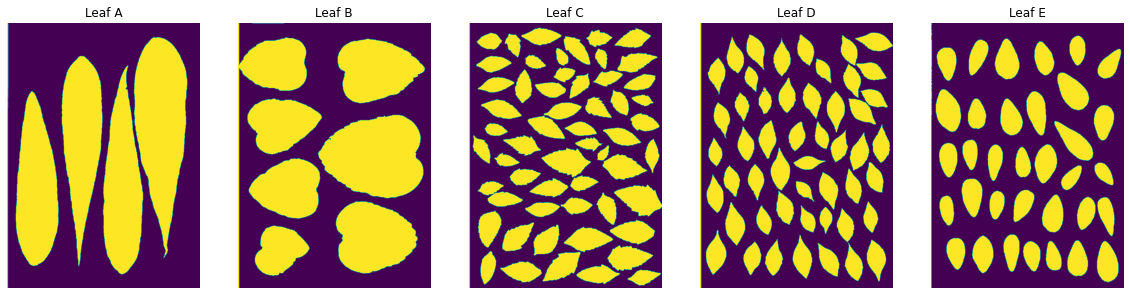

In [13]:
cleaned_imgs = [area_opening(area_closing(x,100),100) for x in binarized_imgs]
titles = ['Leaf A', 'Leaf B', 'Leaf C', 'Leaf D', 'Leaf E',]

fig, axs = plt.subplots(1, 5, figsize=(20,8))

for i, ax in enumerate(axs):
    ax.imshow(cleaned_imgs[i])
    ax.axis('off')
    ax.set_title(titles[i]);

Once the leaves have been cleaned up, I label them.

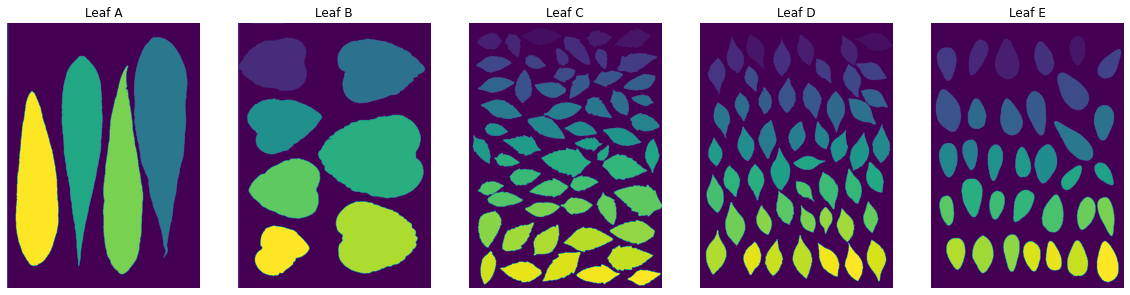

In [14]:
labeled_imgs = [label(x) for x in cleaned_imgs]
titles = ['Leaf A', 'Leaf B', 'Leaf C', 'Leaf D', 'Leaf E',]

fig, axs = plt.subplots(1, 5, figsize=(20,8))

for i, ax in enumerate(axs):
    ax.imshow(labeled_imgs[i])
    ax.axis('off')
    ax.set_title(titles[i]);

I use these labels and get th region properties. I do this for every leaf type.

In [15]:
def get_properties(leaf_type):
    filepaths = img_df[img_df['type'] == leaf_type].path
    properties = ['area','convex_area','bbox_area','major_axis_length', 
                  'minor_axis_length', 'perimeter', 'equivalent_diameter',
                  'mean_intensity', 'solidity', 'eccentricity']
    dataframe = pd.DataFrame(columns=properties)
    for file in filepaths:
        grayscale = rgb2gray(imread(file))
        threshold = threshold_otsu(grayscale)
        binarized = grayscale < threshold         
        closed = area_closing(binarized, 1000)
        opened = area_opening(closed, 1000)
        labeled = label(opened)
        regions = regionprops(labeled)
        data = pd.DataFrame(regionprops_table(labeled, grayscale, 
                                              properties=properties))
        data = data[(data.index!=0) & (data.area>100)]
        data['type'] = leaf_type
        dataframe = pd.concat([dataframe, data])
    return dataframe

In [16]:
leaf_A = get_properties('A')
leaf_B = get_properties('B')
leaf_C = get_properties('C')
leaf_D = get_properties('D')
leaf_E = get_properties('E')

print("Data Distribution per Leaf Type")
len(leaf_A), len(leaf_B), len(leaf_C), len(leaf_D), len(leaf_E)

Data Distribution per Leaf Type


(51, 47, 55, 50, 53)

The data looks. . . more or less balanced. I don't have to deal with dataset imbalance here. I add a few more features to our data, to be able to predict better. I have to find him.

In [17]:
df = pd.concat([leaf_A, leaf_B, leaf_C, leaf_D, leaf_E])

df['ratio_length'] = df['major_axis_length'] / df['minor_axis_length']
df['perimeter_ratio_major'] = df['perimeter'] / df['major_axis_length']
df['perimeter_ratio_minor'] = df['perimeter'] / df['minor_axis_length']
df['area_ratio_convex'] = df['area'] / df['convex_area']
df['area_ratio_bbox'] = df['area'] / df['bbox_area']
df['peri_over_dia'] = df['perimeter'] / df['equivalent_diameter']

df_data = df[df.drop('type', axis=1).columns].astype(float)
df_data = df_data.replace(np.inf, 0)
df_data['type'] = df['type']
df_data

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity,ratio_length,perimeter_ratio_major,perimeter_ratio_minor,area_ratio_convex,area_ratio_bbox,peri_over_dia,type
1,81168.0,86379.0,128656.0,646.664244,167.623828,1649.874242,321.475205,0.156345,0.939673,0.965820,3.857830,2.551361,9.842719,0.939673,0.630892,5.132197,A
2,57761.0,60567.0,93130.0,611.657905,127.524455,1526.329040,271.189213,0.154478,0.953671,0.978025,4.796397,2.495397,11.968912,0.953671,0.620219,5.628281,A
3,60063.0,63960.0,91080.0,641.740818,124.130115,1520.364574,276.540389,0.151895,0.939071,0.981115,5.169904,2.369126,12.248153,0.939071,0.659453,5.497803,A
4,58214.0,59138.0,81498.0,560.578865,135.902883,1292.766594,272.250559,0.154889,0.984376,0.970168,4.124849,2.306128,9.512429,0.984376,0.714300,4.748444,A
1,85573.0,90653.0,146877.0,753.110692,153.389949,1892.419444,330.083213,0.111763,0.943962,0.979039,4.909779,2.512804,12.337311,0.943962,0.582617,5.733159,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,3619.0,3691.0,5088.0,93.300191,50.049722,244.793939,67.881175,0.227478,0.980493,0.843940,1.864150,2.623724,4.891015,0.980493,0.711281,3.606212,E
16,6337.0,6443.0,8470.0,119.856064,67.478982,317.078210,89.824935,0.218282,0.983548,0.826457,1.776198,2.645492,4.698918,0.983548,0.748170,3.529958,E
17,4345.0,4422.0,6588.0,111.896530,50.538035,278.936075,74.378934,0.243527,0.982587,0.892195,2.214105,2.492804,5.519330,0.982587,0.659532,3.750203,E
18,4469.0,4555.0,6060.0,99.248680,58.286507,267.036580,75.432801,0.213214,0.981120,0.809386,1.702773,2.690581,4.581448,0.981120,0.737459,3.540059,E


I carefully select the way I split my data, into train, test, and validation sets.

In [18]:
trainval_df, test_df = train_test_split(df_data, test_size=0.2, random_state=22)

"Train-val and test split", len(trainval_df), len(test_df)

('Train-val and test split', 204, 52)

In [19]:
train_df, val_df = train_test_split(trainval_df, test_size=0.1, random_state=22)

"Train and val split", len(train_df), len(val_df)

('Train and val split', 183, 21)

In [20]:
X_train, y_train = train_df[train_df.columns.drop('type')], train_df['type']
X_test, y_test = test_df[test_df.columns.drop('type')], test_df['type']
X_val, y_val = val_df[val_df.columns.drop('type')], val_df['type']

And now, for the final step, using machine learning for my own ends. Good performance, and it doesn't overfit, given the accuracy for the validation set.

In [21]:
RF = RandomForestClassifier(max_depth=7, n_estimators=100)
RF.fit(X_train, y_train)
y_pred_RF= RF.predict(X_test)

df = pd.DataFrame()

cols = ['Machine Learning Classification Method',
        'Train Accuracy',
        'Validation Accuracy',
        'Test Accuracy',
        "Top 1 Feature Predictor",
        "Top 2 Feature Predictor",
        "Top 3 Feature Predictor",
        "Top 4 Feature Predictor",
        "Top 5 Feature Predictor"]

df.loc['Machine Learning Classification Method', 
       'Details'] = 'Random Forest Classifier'
df.loc['Train Accuracy', 'Details'] = RF.score(X_train, y_train) 
df.loc['Validation Accuracy', 'Details'] = RF.score(X_val, y_val)
df.loc['Test Accuracy', 'Details'] = RF.score(X_test, y_test)

feature_importances = df_data.columns[np.argsort(RF.feature_importances_)][-5:]
df.loc['Top 1 Feature Predictor', 'Details'] = feature_importances[4]
df.loc['Top 2 Feature Predictor', 'Details'] = feature_importances[3]
df.loc['Top 3 Feature Predictor', 'Details'] = feature_importances[2]
df.loc['Top 4 Feature Predictor', 'Details'] = feature_importances[1]
df.loc['Top 5 Feature Predictor', 'Details'] = feature_importances[0]

display(df)

,Details
Machine Learning Classification Method,Random Forest Classifier
Train Accuracy,1.0
Validation Accuracy,1.0
Test Accuracy,0.961538
Top 1 Feature Predictor,mean_intensity
Top 2 Feature Predictor,solidity
Top 3 Feature Predictor,area_ratio_convex
Top 4 Feature Predictor,eccentricity
Top 5 Feature Predictor,ratio_length


Given these results, I realize a few things. The edges of the leaves, how jagged they are, is reflected by the mean intensity of our leaf. And that is the most important feature. I think he's sending me a message with that.

<p class='intro'>The edges of each leaf, both jagged and smooth, they tell me things you do not. They tell me of your of your fear to let me love you, lest I get hurt. Obviously, there are still some things that you have kept from me. You wield a sword, your life must be full of danger. And you don't want me hurt. That's what you're trying to say. But I am not afraid. I can take care of myself. I am stronger than you think.</p>
<p class='intro'><i>Let me love you. . . xoxo</i></p>